![https://miro.medium.com/max/1180/1*4r8q_WiW97CRmxPaCaAQ4Q.jpeg](https://miro.medium.com/max/1180/1*4r8q_WiW97CRmxPaCaAQ4Q.jpeg)

#  Delay Estimator

Spark application that creates a machine learning model for a real-world problem, using real-world data: Predicting the arrival delay of commercial flights

- Our mission is to predict the total Delay on Arrival
- Our variable target is [ARR_Delay]


## Spark Setup

![https://miro.medium.com/max/1400/1*wiXLNwwMyWdyyBuzZnGrWA.png](https://miro.medium.com/max/1400/1*wiXLNwwMyWdyyBuzZnGrWA.png)

In [28]:
# Setar o ambiente para uso de Python no Spark
import support_functions as sf
sf.set_spark_python()

# Criar a sessao do Spark
from pyspark import SparkConf, SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
spark = SparkSession \
            .builder \
            .master("local[2]") \
            .appName("Pedro Spark Machine") \
            .getOrCreate()

In [29]:
spark

In [30]:
sc = spark.sparkContext

In [31]:
sc.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.cores.max', '3'),
 ('spark.app.id', 'local-1624720366529'),
 ('spark.driver.port', '33471'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Pedro Spark Machine'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'ip-172-31-39-225.ec2.internal'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[2]')]

## Incrise machine parameters

In [32]:
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), \
                                        ('spark.executor.cores', '3'), \
                                        ('spark.cores.max', '3'),\
                                        ('spark.driver.memory','4g')])
sc.stop()

In [33]:
sc.getConf().getAll()

[('spark.driver.memory', '4g'),
 ('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.cores.max', '3'),
 ('spark.app.id', 'local-1624720366529'),
 ('spark.driver.port', '33471'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Pedro Spark Machine'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.cores', '3'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', 'ip-172-31-39-225.ec2.internal'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.master', 'local[2]')]

In [34]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [35]:
from pyspark.sql import functions as sf
from pyspark.sql.types import *
from pyspark.sql import Row

# Data Dictionary

In [36]:
df_dict = spark.read.csv('./Data/projeto_final_dicionário.csv')

In [37]:
df_dict.show(31)

+-------------------+--------------------+---------------+--------+
|                _c0|                 _c1|            _c2|     _c3|
+-------------------+--------------------+---------------+--------+
|               Name|         Description|   Type(Format)| Example|
|            FL_DATE|  Date of the flight|DATE (yy/mm/dd)|5/2/2009|
|         OP_CARRIER|  Airline Identifier|         STRING|      9E|
|  OP_CARRIER_FL_NUM|       Flight Number|        INTEGER|    2216|
|             ORIGIN|Starting Airport ...|         STRING|     MLI|
|               DEST|Destination Airpo...|         STRING|     MEM|
|       CRS_DEP_TIME|Planned Departure...|        INTEGER|     600|
|           DEP_TIME|Actual Departure ...|          FLOAT|   603.0|
|          DEP_DELAY|Total Delay on De...|          FLOAT|     3.0|
|           TAXI_OUT|The time duration...|          FLOAT|    14.0|
|         WHEELS_OFF|The time point th...|          FLOAT|   617.0|
|          WHEELS_ON|The time point th...|      

# Reading Files



In [38]:
df = spark.read.csv('../../10_dados/projeto/2009.csv', header=True)

In [39]:
# Define a Schema

labels = ( 
    ('FL_DATE', StringType()),
    ('OP_CARRIER', StringType()),
    ('OP_CARRIER_FL_NUM',IntegerType()),
    ('ORIGIN',StringType()),
    ('DEST',StringType()),
    ('CRS_DEP_TIME',IntegerType()),
    ('DEP_TIME',FloatType()),
    ('DEP_DELAY',FloatType()),
    ('TAXI_OUT',FloatType()),
    ('WHEELS_OFF',FloatType()),
    ('WHEELS_ON',FloatType()),
    ('TAXI_IN',FloatType()),
    ('CRS_ARR_TIME',IntegerType()),
    ('ARR_TIME',FloatType()),
    ('ARR_DELAY',FloatType()),
    ('CANCELLED',FloatType()),
    ('CANCELLATION_CODE',StringType()),
    ('DIVERTED',FloatType()),
    ('CRS_ELAPSED_TIME',FloatType()),
    ('ACTUAL_ELAPSED_TIME',FloatType()),
    ('AIR_TIME',FloatType()),
    ('DISTANCE',FloatType()),
    ('CARRIER_DELAY',FloatType()),
    ('WEATHER_DELAY',FloatType()),
    ('NAS_DELAY',FloatType()),
    ('SECURITY_DELAY',FloatType()),
    ('LATE_AIRCRAFT_DELAY',StringType()),
)

In [40]:
my_schema = StructType([StructField(x[0], x[1], True) for x in labels])

In [41]:
df = spark.read.csv('../../10_dados/projeto/2009.csv', 
                    header=True, 
                    schema = my_schema)

In [42]:
df.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: float (nullable = true)
 |-- DEP_DELAY: float (nullable = true)
 |-- TAXI_OUT: float (nullable = true)
 |-- WHEELS_OFF: float (nullable = true)
 |-- WHEELS_ON: float (nullable = true)
 |-- TAXI_IN: float (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: float (nullable = true)
 |-- ARR_DELAY: float (nullable = true)
 |-- CANCELLED: float (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: float (nullable = true)
 |-- CRS_ELAPSED_TIME: float (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: float (nullable = true)
 |-- AIR_TIME: float (nullable = true)
 |-- DISTANCE: float (nullable = true)
 |-- CARRIER_DELAY: float (nullable = true)
 |-- WEATHER_DELAY: float (nullable =

In [43]:
df.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+
|2009-01-01|        XE|             1

In [44]:
%%time
datasize = df.count()
print(f'Data Size is: {datasize} rows')

Data Size is: 6429338 rows
CPU times: user 4.31 ms, sys: 1.06 ms, total: 5.37 ms
Wall time: 1.92 s


# Visualization

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
plt.style.use('ggplot')

Creating a temporary view for visualization purpose

In [46]:
df.createOrReplaceTempView('flights')

### Wich carrier has the most Delays


In [47]:
%%time

query = '''
SELECT
    OP_CARRIER AS AIRLINE_COMPANY,
    MIN(ARR_DELAY) AS MIN_DELAY,
    MAX(ARR_DELAY) AS MAX_DELAY,
    ROUND(AVG(ARR_DELAY), 2) AS AVG_DELAY,
    SUM(ARR_DELAY) AS SUM_DELAY
FROM flights 
GROUP BY OP_CARRIER
ORDER BY AVG_DELAY DESC

'''
carrier_delays = spark.sql(query).show()

+---------------+---------+---------+---------+---------+
|AIRLINE_COMPANY|MIN_DELAY|MAX_DELAY|AVG_DELAY|SUM_DELAY|
+---------------+---------+---------+---------+---------+
|             EV|    -59.0|    708.0|    11.72|3417311.0|
|             OH|    -77.0|    680.0|    10.69|1554748.0|
|             FL|    -58.0|   1088.0|      8.2|2028392.0|
|             YV|    -66.0|    940.0|     6.04|1437329.0|
|             MQ|    -57.0|   1175.0|     5.97|2529714.0|
|             XE|    -71.0|    714.0|     5.75|1744487.0|
|             F9|    -48.0|    745.0|     5.69| 491380.0|
|             AA|    -96.0|   1305.0|     5.67|3056631.0|
|             CO|    -85.0|    947.0|     5.51|1402539.0|
|             B6|    -92.0|    823.0|     5.08| 970361.0|
|             DL|    -95.0|    879.0|     4.84|2034515.0|
|             NW|    -88.0|   2449.0|     3.92|1138401.0|
|             OO|    -95.0|    901.0|      3.3|1775369.0|
|             US|    -80.0|    668.0|     2.09| 848998.0|
|             

In [48]:
carrier_delays = spark.sql(query).toPandas()

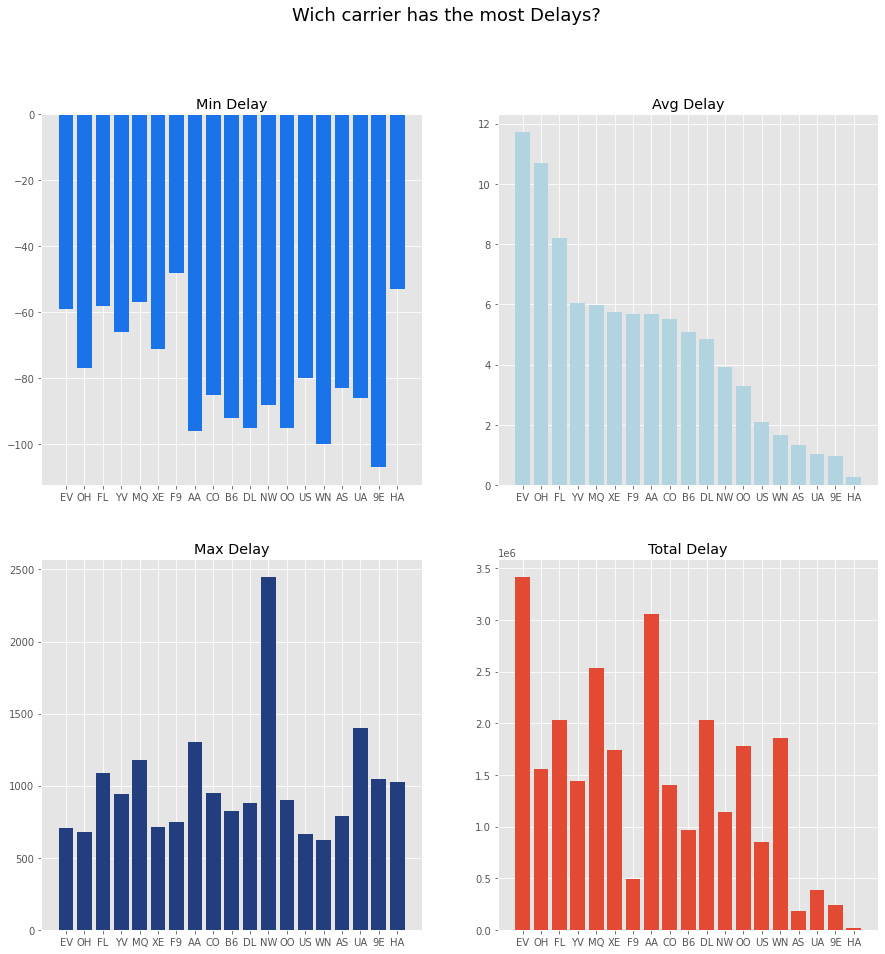

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].bar(carrier_delays.AIRLINE_COMPANY, carrier_delays.MIN_DELAY, color='#1a73e8') #row=0, col=0
ax[0, 0].title.set_text('Min Delay')
ax[1, 0].bar(carrier_delays.AIRLINE_COMPANY, carrier_delays.MAX_DELAY, color='#223e7f') #row=1, col=0
ax[1, 0].title.set_text('Max Delay')
ax[0, 1].bar(carrier_delays.AIRLINE_COMPANY, carrier_delays.AVG_DELAY, color = '#B1D4E0')#row=0, col=1
ax[0, 1].title.set_text('Avg Delay')
ax[1, 1].bar(carrier_delays.AIRLINE_COMPANY, carrier_delays.SUM_DELAY) #row=1, col=1
ax[1, 1].title.set_text('Total Delay')
plt.suptitle("Wich carrier has the most Delays?", size=18)
plt.show()

### How many flights were cancelled

In [50]:
%%time
query = '''
SELECT
    CANCELLED,
    COUNT(OP_CARRIER_FL_NUM)
FROM flights 
GROUP BY CANCELLED
'''
cancelled_flights = spark.sql(query).toPandas()

CPU times: user 6.7 ms, sys: 4.06 ms, total: 10.8 ms
Wall time: 7.01 s


Text(0.5, 1.0, 'How many flights were cancelled')

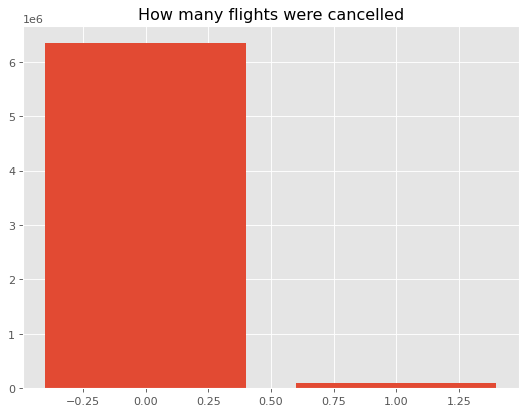

In [51]:
figure(figsize=(8, 6), dpi=80)
plt.bar(cancelled_flights.CANCELLED, cancelled_flights['count(OP_CARRIER_FL_NUM)'])
plt.title('How many flights were cancelled')

### Which carrier has the most cancelled flights?

In [52]:
%%time

query = '''
SELECT
    OP_CARRIER AS AIRLINE_COMPANY,
    COUNT(OP_CARRIER) AS CANCELLED_FLIGHTS 
FROM flights
WHERE CANCELLED = 1
GROUP BY OP_CARRIER 
ORDER BY CANCELLED_FLIGHTS DESC
'''
#spark.sql(query).show()
carrier_cancelled = spark.sql(query).toPandas()

CPU times: user 11.4 ms, sys: 437 µs, total: 11.8 ms
Wall time: 7.37 s


Text(0.5, 1.0, 'Which carrier has the most cancelled flights?')

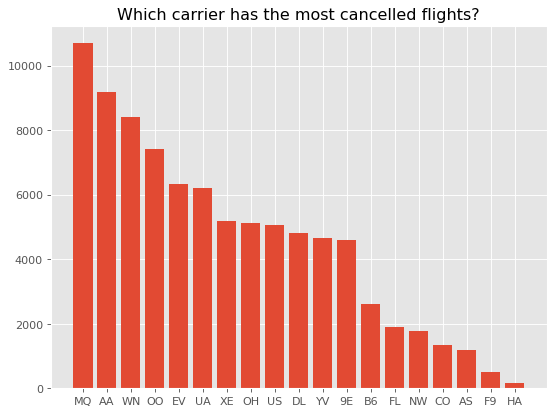

In [53]:
figure(figsize=(8, 6), dpi=80)
plt.bar(carrier_cancelled.AIRLINE_COMPANY, carrier_cancelled.CANCELLED_FLIGHTS)
plt.title('Which carrier has the most cancelled flights?')

### Which origin and destination airports have the most delays?

#### Origin

In [54]:
%%time

query = '''
SELECT
    ORIGIN,
    MIN(ARR_DELAY) AS MIN_DELAY,
    MAX(ARR_DELAY) AS MAX_DELAY,
    ROUND(AVG(ARR_DELAY), 2) AS AVG_DELAY,
    SUM(ARR_DELAY) AS SUM_DELAY
FROM flights 
GROUP BY ORIGIN
ORDER BY AVG_DELAY DESC
'''
#spark.sql(query).show()
origin_delays = spark.sql(query).toPandas()
origin_delays = origin_delays.head(10)

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 10.2 s


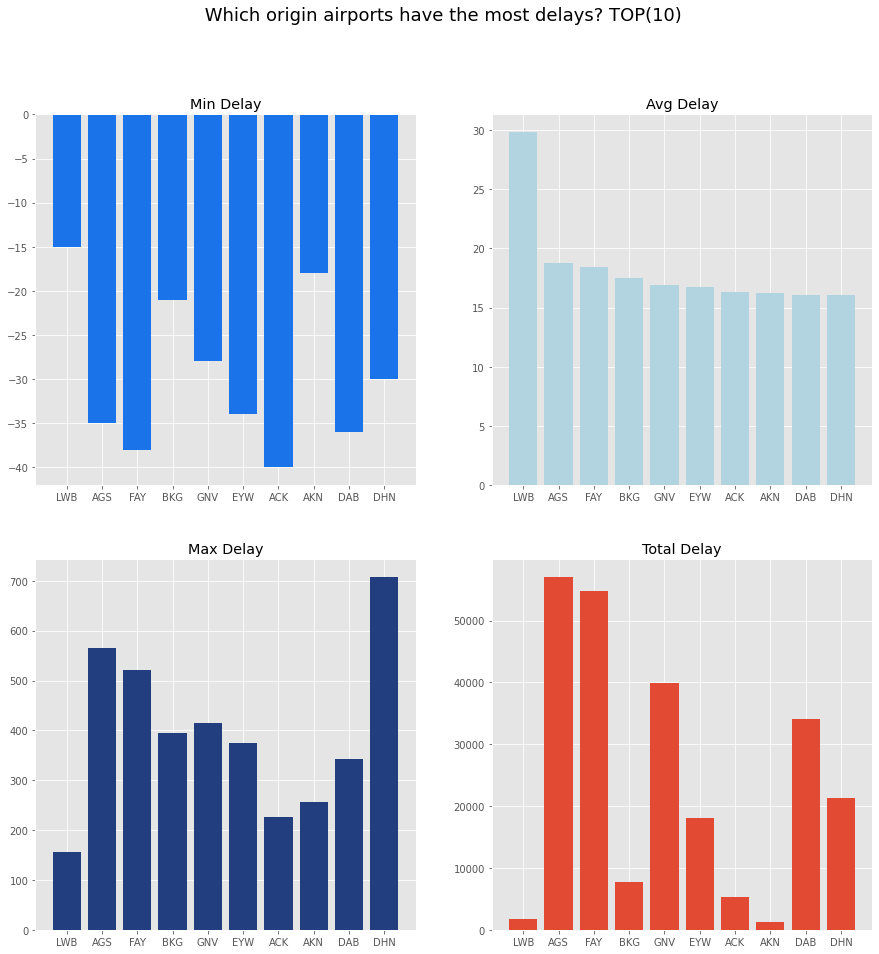

In [55]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].bar(origin_delays.ORIGIN, origin_delays.MIN_DELAY, color='#1a73e8') #row=0, col=0
ax[0, 0].title.set_text('Min Delay')
ax[1, 0].bar(origin_delays.ORIGIN, origin_delays.MAX_DELAY, color='#223e7f') #row=1, col=0
ax[1, 0].title.set_text('Max Delay')
ax[0, 1].bar(origin_delays.ORIGIN, origin_delays.AVG_DELAY, color = '#B1D4E0')#row=0, col=1
ax[0, 1].title.set_text('Avg Delay')
ax[1, 1].bar(origin_delays.ORIGIN, origin_delays.SUM_DELAY) #row=1, col=1
ax[1, 1].title.set_text('Total Delay')
plt.suptitle(" Which origin airports have the most delays? TOP(10)", size=18)
plt.show()

#### Destination

In [56]:
%%time

query = '''
SELECT
    DEST,
    MIN(ARR_DELAY) AS MIN_DELAY,
    MAX(ARR_DELAY) AS MAX_DELAY,
    ROUND(AVG(ARR_DELAY), 2) AS AVG_DELAY,
    SUM(ARR_DELAY) AS SUM_DELAY
FROM flights 
GROUP BY DEST
ORDER BY AVG_DELAY DESC
'''
dest_delays = spark.sql(query).toPandas()
dest_delays = dest_delays.head(10)

CPU times: user 12.9 ms, sys: 619 µs, total: 13.5 ms
Wall time: 10.3 s


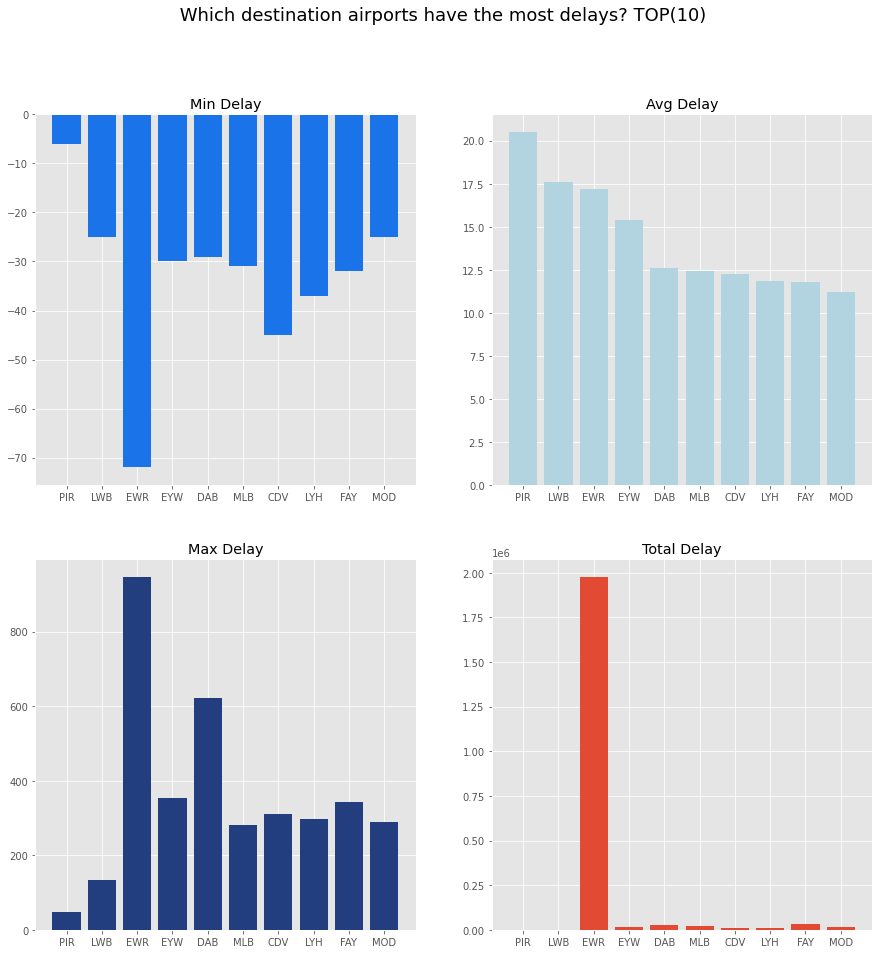

In [57]:
fig, ax = plt.subplots(2, 2, figsize=(15,15))
ax[0, 0].bar(dest_delays.DEST, dest_delays.MIN_DELAY, color='#1a73e8') #row=0, col=0
ax[0, 0].title.set_text('Min Delay')
ax[1, 0].bar(dest_delays.DEST, dest_delays.MAX_DELAY, color='#223e7f') #row=1, col=0
ax[1, 0].title.set_text('Max Delay')
ax[0, 1].bar(dest_delays.DEST, dest_delays.AVG_DELAY, color = '#B1D4E0')#row=0, col=1
ax[0, 1].title.set_text('Avg Delay')
ax[1, 1].bar(dest_delays.DEST, dest_delays.SUM_DELAY) #row=1, col=1
ax[1, 1].title.set_text('Total Delay')
plt.suptitle(" Which destination airports have the most delays? TOP(10)", size=18)
plt.show()

### What causes the most delay

In [58]:
%%time
query_1='''
SELECT
    ROUND(AVG(SECURITY_DELAY), 2) AS SECURITY,
    ROUND(AVG(NAS_DELAY), 2) AS AIR_SYSTEM,
    ROUND(AVG(WEATHER_DELAY), 2) AS WEATHER,
    ROUND(AVG(CARRIER_DELAY), 2) AS CARRIER,
    ROUND(AVG(DEP_DELAY), 2) AS DEPARTURE
FROM flights
'''
query_2='''
SELECT
    ROUND(MAX(SECURITY_DELAY), 2) AS SECURITY,
    ROUND(MAX(NAS_DELAY), 2) AS AIR_SYSTEM,
    ROUND(MAX(WEATHER_DELAY), 2) AS WEATHER,
    ROUND(MAX(CARRIER_DELAY), 2) AS CARRIER,
    ROUND(MAX(DEP_DELAY), 2) AS DEPARTURE
FROM flights
'''
avg_delay = spark.sql(query_1).toPandas()
max_delay = spark.sql(query_2).toPandas()

CPU times: user 20.5 ms, sys: 0 ns, total: 20.5 ms
Wall time: 14.5 s


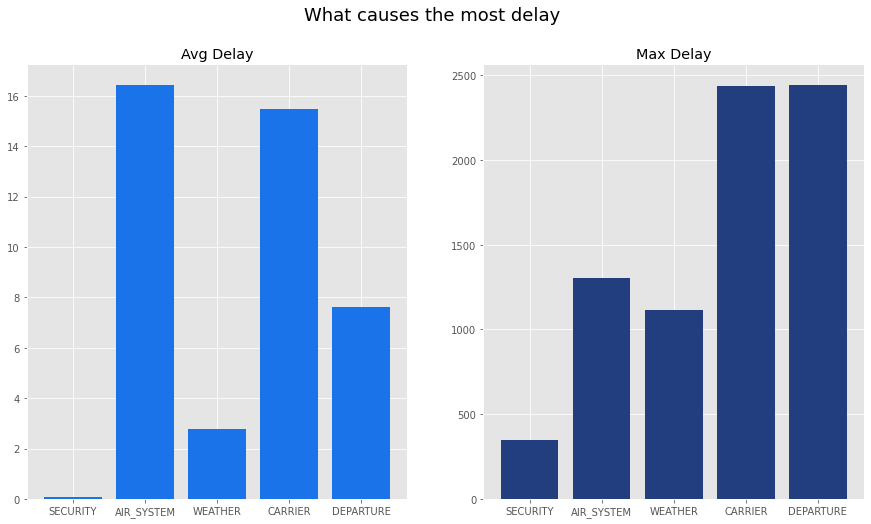

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.bar(avg_delay.columns, avg_delay.values[0], color='#1a73e8') #row=0, col=0
ax1.title.set_text('Avg Delay')
ax2.bar(max_delay.columns, max_delay.values[0], color='#223e7f') #row=1, col=0
ax2.title.set_text('Max Delay')
plt.suptitle("What causes the most delay", size=18)
plt.show()

# Missing values

In [60]:
df_dictionary = df_dict.toPandas()
for element in df_dictionary['_c0']:
    print(f'COUNT(*)-COUNT({element}) AS {element},')

COUNT(*)-COUNT(Name) AS Name,
COUNT(*)-COUNT(FL_DATE) AS FL_DATE,
COUNT(*)-COUNT(OP_CARRIER) AS OP_CARRIER,
COUNT(*)-COUNT(OP_CARRIER_FL_NUM) AS OP_CARRIER_FL_NUM,
COUNT(*)-COUNT(ORIGIN) AS ORIGIN,
COUNT(*)-COUNT(DEST) AS DEST,
COUNT(*)-COUNT(CRS_DEP_TIME) AS CRS_DEP_TIME,
COUNT(*)-COUNT(DEP_TIME) AS DEP_TIME,
COUNT(*)-COUNT(DEP_DELAY) AS DEP_DELAY,
COUNT(*)-COUNT(TAXI_OUT) AS TAXI_OUT,
COUNT(*)-COUNT(WHEELS_OFF) AS WHEELS_OFF,
COUNT(*)-COUNT(WHEELS_ON) AS WHEELS_ON,
COUNT(*)-COUNT(TAXI_IN) AS TAXI_IN,
COUNT(*)-COUNT(CRS_ARR_TIME) AS CRS_ARR_TIME,
COUNT(*)-COUNT(ARR_TIME) AS ARR_TIME,
COUNT(*)-COUNT(ARR_DELAY) AS ARR_DELAY,
COUNT(*)-COUNT(CANCELLED) AS CANCELLED,
COUNT(*)-COUNT(CANCELLATION_CODE) AS CANCELLATION_CODE,
COUNT(*)-COUNT(DIVERTED) AS DIVERTED,
COUNT(*)-COUNT(CRS_ELAPSED_TIME) AS CRS_ELAPSED_TIME,
COUNT(*)-COUNT(ACTUAL_ELAPSED_TIME) AS ACTUAL_ELAPSED_TIME,
COUNT(*)-COUNT(AIR_TIME) AS AIR_TIME,
COUNT(*)-COUNT(DISTANCE) AS DISTANCE,
COUNT(*)-COUNT(CARRIER_DELAY) AS CARRIER_DEL

In [61]:
%%time

query = '''
SELECT
    COUNT(*)-COUNT(FL_DATE) AS FL_DATE,
    COUNT(*)-COUNT(OP_CARRIER) AS OP_CARRIER,
    COUNT(*)-COUNT(OP_CARRIER_FL_NUM) AS OP_CARRIER_FL_NUM,
    COUNT(*)-COUNT(ORIGIN) AS ORIGIN,
    COUNT(*)-COUNT(DEST) AS DEST,
    COUNT(*)-COUNT(CRS_DEP_TIME) AS CRS_DEP_TIME,
    COUNT(*)-COUNT(DEP_TIME) AS DEP_TIME,
    COUNT(*)-COUNT(DEP_DELAY) AS DEP_DELAY,
    COUNT(*)-COUNT(TAXI_OUT) AS TAXI_OUT,
    COUNT(*)-COUNT(WHEELS_OFF) AS WHEELS_OFF,
    COUNT(*)-COUNT(WHEELS_ON) AS WHEELS_ON,
    COUNT(*)-COUNT(TAXI_IN) AS TAXI_IN,
    COUNT(*)-COUNT(CRS_ARR_TIME) AS CRS_ARR_TIME,
    COUNT(*)-COUNT(ARR_TIME) AS ARR_TIME,
    COUNT(*)-COUNT(ARR_DELAY) AS ARR_DELAY,
    COUNT(*)-COUNT(CANCELLED) AS CANCELLED,
    COUNT(*)-COUNT(CANCELLATION_CODE) AS CANCELLATION_CODE,
    COUNT(*)-COUNT(DIVERTED) AS DIVERTED,
    COUNT(*)-COUNT(CRS_ELAPSED_TIME) AS CRS_ELAPSED_TIME,
    COUNT(*)-COUNT(ACTUAL_ELAPSED_TIME) AS ACTUAL_ELAPSED_TIME,
    COUNT(*)-COUNT(AIR_TIME) AS AIR_TIME,
    COUNT(*)-COUNT(DISTANCE) AS DISTANCE,
    COUNT(*)-COUNT(CARRIER_DELAY) AS CARRIER_DELAY,
    COUNT(*)-COUNT(WEATHER_DELAY) AS WEATHER_DELAY,
    COUNT(*)-COUNT(NAS_DELAY) AS NAS_DELAY,
    COUNT(*)-COUNT(SECURITY_DELAY) AS SECURITY_DELAY,
    COUNT(*)-COUNT(LATE_AIRCRAFT_DELAY) AS LATE_AIRCRAFT_DELAY
FROM flights 
'''
df_missing = spark.sql(query).toPandas()
for element in df_missing.columns:
    print(element, df_missing[element].iloc[0])

FL_DATE 0
OP_CARRIER 0
OP_CARRIER_FL_NUM 0
ORIGIN 0
DEST 0
CRS_DEP_TIME 0
DEP_TIME 82867
DEP_DELAY 82867
TAXI_OUT 85787
WHEELS_OFF 85787
WHEELS_ON 89322
TAXI_IN 89321
CRS_ARR_TIME 0
ARR_TIME 89322
ARR_DELAY 102361
CANCELLED 0
CANCELLATION_CODE 6342300
DIVERTED 0
CRS_ELAPSED_TIME 0
ACTUAL_ELAPSED_TIME 102362
AIR_TIME 102361
DISTANCE 0
CARRIER_DELAY 5258837
WEATHER_DELAY 5258837
NAS_DELAY 5258837
SECURITY_DELAY 5258837
LATE_AIRCRAFT_DELAY 5258837
CPU times: user 40.4 ms, sys: 6.11 ms, total: 46.6 ms
Wall time: 36.4 s


# Data preparation

In [62]:
df_filtered = df.filter("""
DEP_DELAY IS NOT NULL and 
TAXI_OUT IS NOT NULL and 
TAXI_IN IS NOT NULL and 
ARR_TIME IS NOT NULL and 
ARR_DELAY IS NOT NULL and
CANCELLED IS NOT NULL and  
CRS_ELAPSED_TIME IS NOT NULL and
ACTUAL_ELAPSED_TIME IS NOT NULL and 
AIR_TIME IS NOT NULL and 
DISTANCE IS NOT NULL and 
CARRIER_DELAY IS NOT NULL and 
WEATHER_DELAY IS NOT NULL and 
NAS_DELAY IS NOT NULL and 
SECURITY_DELAY IS NOT NULL and 
LATE_AIRCRAFT_DELAY IS NOT NULL and
""")

# Modeling

 Only considering features that you are aware of before the plane takes off.

- OP_CARRIER
- ORIGIN
- DEST
- DEP_DELAY
- TAXI_OUT
- DISTANCE
- CARRIER_DELAY
- WEATHER_DELAY
- NAS_DELAY
- SECURITY_DELAY

## Pipeline Model

### OneHotEncoder, StringIndexer

To apply OneHotEncoder on categorical values it's necessary to have a index column. That's why it's necessary to use StringIndexer

In [63]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler 
from pyspark.ml.feature import OneHotEncoder,StringIndexer

categoricalCols = ['OP_CARRIER', 'ORIGIN', 'DEST']

numericCols = ['DEP_DELAY', 'DISTANCE', 'TAXI_OUT',\
               'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', \
               'SECURITY_DELAY']

indexOutputCols = [x + "_Index" for x in categoricalCols]
oneOutputCols = [x + "_OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols=categoricalCols,
                             outputCols=indexOutputCols,
                             handleInvalid='skip')

oheEncoder = OneHotEncoder(inputCols=indexOutputCols,
                           outputCols=oneOutputCols)

assemblerInputs = oneOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols=assemblerInputs,
                              outputCol = 'features')

# # Just to see the output from OnehotEncoder
# oheEncoder.fit(stringIndexer.fit(train).transform(train)) \
#           .transform(stringIndexer.fit(train).transform(train)) \
#           .select('OP_CARRIER', 'OP_CARRIER_OHE', 'OP_CARRIER_Index').show(5)

### Train and test split

In [64]:
train, test = df_filtered.randomSplit([0.7, 0.3], seed=42)

## Linear Regression

In [65]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='ARR_DELAY')



pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

import time
start = time.process_time()
pipelineModel = pipeline.fit(train)  
print(time.process_time() - start)
pred = pipelineModel.transform(test)

0.0694573079999996


In [66]:
pred.select('OP_CARRIER','ARR_DELAY', 'features', 'prediction').show(5)

+----------+---------+--------------------+------------------+
|OP_CARRIER|ARR_DELAY|            features|        prediction|
+----------+---------+--------------------+------------------+
|        9E|     19.0|(614,[15,32,413,6...|30.878739481117744|
|        9E|     26.0|(614,[15,47,328,6...|27.222427574545726|
|        9E|     31.0|(614,[15,47,407,6...|38.601932051681494|
|        9E|     38.0|(614,[15,47,392,6...| 43.54603846259174|
|        9E|     49.0|(614,[15,119,341,...|54.622605197232154|
+----------+---------+--------------------+------------------+
only showing top 5 rows



### Evaluation

In [67]:
from pyspark.ml.evaluation import RegressionEvaluator

regressionEvaluator = RegressionEvaluator(predictionCol='prediction',
                                          labelCol='ARR_DELAY',
                                          metricName='rmse')
lr_rmse = regressionEvaluator.evaluate(pred)
print('RMSE = ', lr_rmse)

RMSE =  11.046810214238155


## Random Forest

In [68]:
%%time
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator


# Train a RandomForest model.
rf = RandomForestRegressor(featuresCol='features', labelCol='ARR_DELAY',
                          maxDepth=8, numTrees=16, seed=42)

# Chain indexer and forest in a Pipeline
pipeline = Pipeline(stages=[stringIndexer, oheEncoder, vecAssembler, rf])

# Train model.  
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)

# Select example rows to display.
predictions.select("prediction", "ARR_DELAY", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="ARR_DELAY", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rf_rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only

+------------------+---------+--------------------+
|        prediction|ARR_DELAY|            features|
+------------------+---------+--------------------+
| 26.38800411157457|     19.0|(614,[15,32,413,6...|
|28.628204177852176|     26.0|(614,[15,47,328,6...|
| 34.98059951470286|     31.0|(614,[15,47,407,6...|
|28.628204177852176|     38.0|(614,[15,47,392,6...|
| 41.57334913584084|     49.0|(614,[15,119,341,...|
+------------------+---------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 20.568
OneHotEncoderModel: uid=OneHotEncoder_acaa9bf2b08c, dropLast=true, handleInvalid=error, numInputCols=3, numOutputCols=3
CPU times: user 93.6 ms, sys: 40.1 ms, total: 134 ms
Wall time: 5min 11s


### Features Importance

In [69]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [70]:
df2 = model.transform(df_filtered)
fi = ExtractFeatureImp(model.stages[-1].featureImportances, df2, "features").head(10)

Text(0.5, 0, 'Scores')

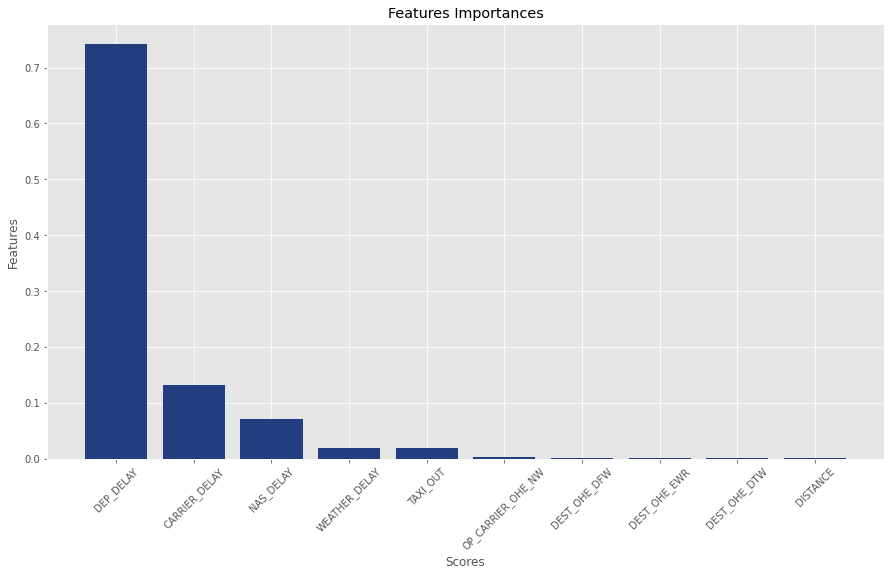

In [71]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.bar(x=fi.name, height=fi.score, color='#223e7f')
plt.title('Features Importances')
plt.tick_params(axis='x', rotation=45)
plt.ylabel('Features')
plt.xlabel('Scores')

# Conclusions